<a href="https://colab.research.google.com/github/iammartian0/Audio101/blob/main/Working_with_dataset/Working_with_audio_data_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Hugging face space datasets library

In [ ]:
!pip install datasets[audio]

In [2]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

Generating train split: 0 examples [00:00, ? examples/s]

Dataset minds14 downloaded and prepared to /root/.cache/huggingface/datasets/PolyAI___minds14/en-AU/1.0.0/65c7e0f3be79e18a6ffaf879a083daf706312d421ac90d25718459cbf3c42696. Subsequent calls will reuse this data.


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

Removing the redundant columns

In [3]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [4]:
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

Changing the sampling rate to match the general sampling_rate using Audio module

In [5]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

Filtering the audio based on length

In [6]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [ ]:
!pip install librosa

In [8]:
import librosa

In [ ]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(filename=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Using the Whisper model to convert the inputs into uniform features

In [ ]:
!pip install transformers

In [11]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [12]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [ ]:
minds = minds.map(prepare_dataset)
minds

Plotting the feature of an example

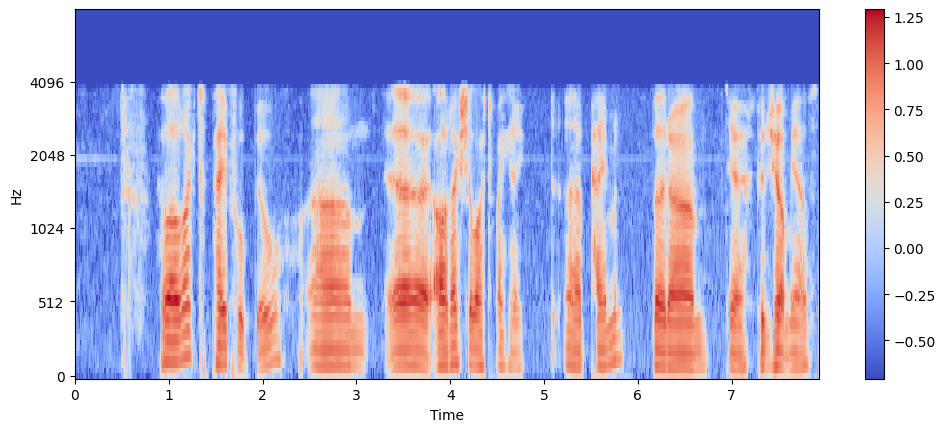

In [14]:
import numpy as np
import matplotlib.pyplot as plt

example = minds[1]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Using streaming feature of datasets to work with large Dataset

In [21]:
gigaspeech = load_dataset("speechcolab/gigaspeech", "xs", streaming=True)

In [22]:
next(iter(gigaspeech["train"]))


{'segment_id': 'YOU0000000315_S0000660',
 'speaker': 'N/A',
 'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
 'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
  'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
         0.00036621]),
  'sampling_rate': 16000},
 'begin_time': 2941.89,
 'end_time': 2945.07,
 'audio_id': 'YOU0000000315',
 'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
 'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
 'source': 2,
 'category': 24,
 'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'}